HandWritten Digit Recognization

1. Train classifier model

In [2]:
import joblib
from sklearn.svm import LinearSVC
from hog import HOG
import dataset

(digits, target) = dataset.load_digits("data/digits.csv")
data = []

hog = HOG(orientations=18, pixelsPerCell=(10,10), cellsPerBlock=(1,1), transform=True)
for image in digits:
    image = dataset.deskew(image, 20)
    dataset.center_extent(image, (20, 20))

    hist = hog.describe(image)
    data.append(hist)

model = LinearSVC(random_state=42)
model.fit(data, target)

joblib.dump(model, "models/svm.cpickle")



['models/svm.cpickle']

2. Apply the trained model to classify handwritten digit

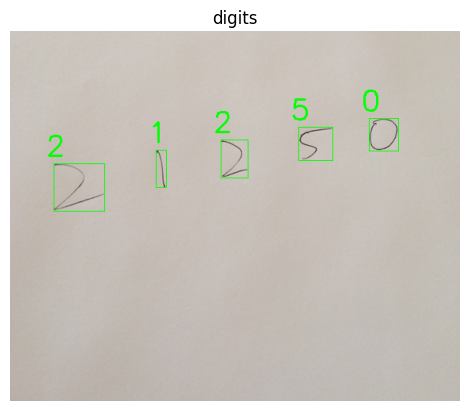

In [5]:
import joblib
import cv2
from hog import HOG
import dataset
import mahotas
import imutils
from helper import draw

model = joblib.load("models/svm.cpickle")
hog = HOG(orientations=18, pixelsPerCell=(10,10), cellsPerBlock=(1,1), transform=True)

image = cv2.imread("images/umbc_zipcode.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = imutils.grab_contours(cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))

cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in cnts], key = lambda x : x[1])

for (c, _) in cnts:
    (x, y, w, h) = cv2.boundingRect(c)

    if w >= 7 and h >= 20:
        roi = gray[y : y + h, x : x + w]
        thresh = roi.copy()
        T = mahotas.thresholding.otsu(roi)
        thresh[thresh > T] = 255
        thresh = cv2.bitwise_not(thresh)

        thresh = dataset.deskew(thresh, 20)
        thresh = dataset.center_extent(thresh, (20, 20))

        hist = hog.describe(thresh)
        digit = model.predict([hist])[0]

        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(image, str(digit), (x - 10, y - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)


draw("digits", image)

